<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from IPython.display import clear_output

import numpy as np
import pandas as pd
import seaborn as sns
import os
import skimage.io
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

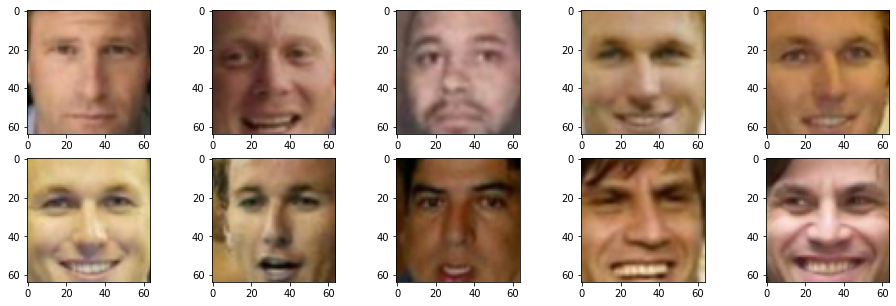

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
plt.figure(figsize=(16, 5))
for i, gt in enumerate(train_photos[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(gt)
    
# Переводим из numpy в torch и меняем размерности для будущих моделей
X_train_t =  torch.permute(torch.tensor(train_photos, dtype=torch.float32), (0, 3, 1, 2)) 
X_val_t =  torch.permute(torch.tensor(val_photos, dtype=torch.float32), (0, 3, 1, 2))

# Оборачиваем в DataLoader для батчевой подгрузки
train_loader = torch.utils.data.DataLoader(X_train_t, batch_size=128, drop_last=True)
val_loader = torch.utils.data.DataLoader(X_val_t, batch_size=128, drop_last=True)

# закидываем loaders в словарь для будущей train func
dataloaders = {}
dataloaders['train'], dataloaders['val'] = train_loader, val_loader 

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
# dim_code = <your code here> # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Encoder_5(nn.Module):
    def __init__(self):
        super(Encoder_5, self).__init__()
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7),
        )
        
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        return x
    
    
class Decoder_5(nn.Module):
    def __init__(self):
        super(Decoder_5, self).__init__()
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)
        )
        
        
    def forward(self, x):
        x = self.decoder_conv(x)
        #print('Decoder convs',x.shape)
        x = torch.sigmoid(x)
        return x

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
import copy
#<тут Ваш код тренировки автоэнкодера>
def train_new(encoder, decoder, optimizer, loss_fn, epochs, data):
    #since = time.time()
    
    best_wts_encoder = copy.deepcopy(encoder.state_dict())
    best_wts_decoder = copy.deepcopy(decoder.state_dict())
    
    best_val_loss = None
    
    train_losses = []
    val_losses = []

    #total_l
    for epoch in range(epochs):
        print(f'Epoch {epoch}')
        
        encoder.train()
        decoder.train()
        running_train_loss = 0.0
        
        for i, X_batch in enumerate(data['train']):
            optimizer.zero_grad()
            #print(X_batch.shape)
            latent_space = encoder(X_batch.to(device))
            #print(latent_space.shape)
            reconstructed = decoder(latent_space)
            #print('Latent_space_dim', latent_space.shape)
            loss = loss_fn(reconstructed, X_batch.to(device))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * X_batch.size(0)
            
        train_losses.append(running_train_loss / len(data['train']))
        
        encoder.eval()
        decoder.eval()
        running_val_loss = 0.0

        for X_batch_val in data['val']:
            
            latent_space_val = encoder(X_batch_val.to(device))
            reconstructed_val = decoder(latent_space_val)
            #print(latent_space_val.shape)
            loss_val = loss_fn(reconstructed_val, X_batch_val.to(device))
            running_val_loss += loss_val.item() * X_batch_val.size(0)

        epoch_val_loss = running_val_loss / len(data['val'])
        val_losses.append(running_val_loss / len(data['val']))

        print('Train loss {:.4f}, Validation loss {:.4f}'.format(running_train_loss / len(data['train']), running_val_loss / len(data['val'])))
        time.sleep(1)

        clear_output(wait=True)
        plt.figure(figsize=(10, 5)) 
        for k in range(5):
            plt.subplot(2, 5, k+1)
            plt.imshow(np.rollaxis(X_batch_val[k].detach().cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real', fontsize=12)          
            plt.axis('off')

            plt.subplot(2, 5, k+6)
            plt.imshow(np.rollaxis(reconstructed_val[k].detach().cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Generated', fontsize=12)
            plt.axis('off')
                       
        plt.show()
        
        if best_val_loss is None:
            best_val_loss = epoch_val_loss
            best_wts_encoder = copy.deepcopy(encoder.state_dict())
            best_wts_decoder = copy.deepcopy(decoder.state_dict())     
        elif epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_wts_encoder = copy.deepcopy(encoder.state_dict())
            best_wts_decoder = copy.deepcopy(decoder.state_dict())   
            
            
    sns.set(style="darkgrid", font_scale=1.4)
    
    plt.title('Train/val losses during training process')
    plt.plot(np.arange(epochs), train_losses, label='train')
    plt.plot(np.arange(epochs), val_losses, label='val')
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    
    print('Best valid loss', best_val_loss)
    return encoder, decoder, train_losses, val_losses

In [ ]:
def small_prep(encoder, decoder):
    loss_fn = F.mse_loss
    lr = 0.001
    torch.manual_seed(42)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    
    optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-04)
    
    return encoder, decoder, optimizer, loss_fn

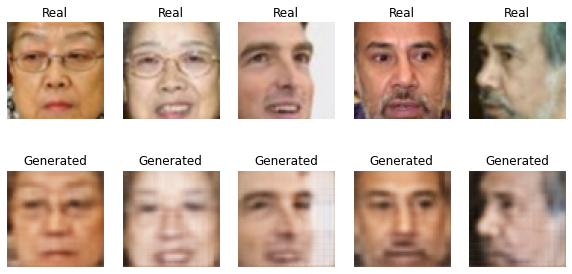

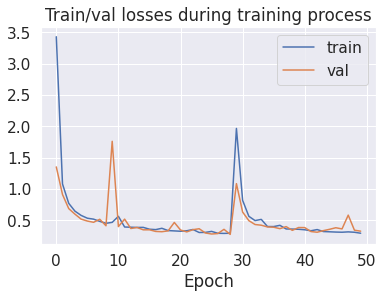

Best valid loss 0.273390406370163
CPU times: user 1min 18s, sys: 5.26 s, total: 1min 23s
Wall time: 2min 23s


In [ ]:
%%time
encoder_5 = Encoder_5().to(device)
decoder_5 = Decoder_5().to(device)

trained_enc_5, trained_dec_5, train_loss_5, val_loss_5 = train_new(*small_prep(encoder_5, decoder_5), 50, dataloaders)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
def eval_and_plot(encoder, decoder):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for batch in dataloaders['val']:
        #print(batch.shape)
            latent_val = trained_enc_5(batch.to(device))
            reconstracted = trained_dec_5(latent_val)
            #print('latent', latent_val.shape)
            reconstruction = np.rollaxis(reconstracted.detach().cpu().numpy(), 1, 4)
            #print(reconstruction.shape)
            ground_truth = np.rollaxis(batch.numpy(), 1, 4)
            #print(ground_truth.shape)
            break
        
    plt.figure(figsize=(10, 5))
    for i, (gt, res) in enumerate(zip(ground_truth[:5], reconstruction[:5])):
        plt.subplot(2, 5, i+1)
        plt.imshow(gt)
        plt.grid(None)
        plt.axis('off')
    
        plt.subplot(2, 5, i+6)
        plt.imshow(res)
        plt.grid(None)
        plt.axis('off')

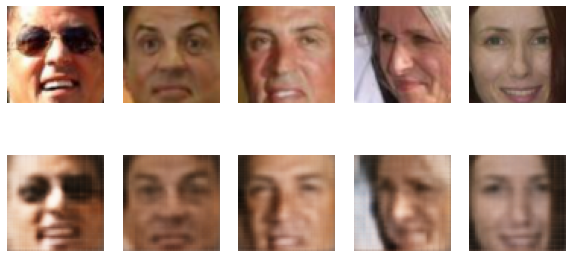

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
eval_and_plot(trained_enc_5, trained_dec_5)

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
def get_latent_vecs(train, encoder):
    latent_vecs = []
    with torch.no_grad():
        for img in train:
            img = img[None,:,:,:]
            latent_space = trained_enc_5(img.to(device))
            latent_vecs.append(latent_space)
    total = torch.cat(latent_vecs, dim=0)        
    return total

def count_mean_std(latent_vecs):
    
    get_mean = torch.mean(latent_vecs, dim=0)
    get_std = torch.std(latent_vecs, dim=0)
    
    return get_mean, get_std

def get_z(mean, std, latent_size):
    # сгенерируем 25 рандомных векторов размера latent_space
    randomize = np.random.randn(10, *latent_size)
    tensored = torch.FloatTensor(randomize)
    z = mean + std * tensored.to(device)
    return z

def decode_and_plot_z(z, decoder):
    #<скормите z декодеру>
    output = decoder(z)
    
    #<выведите тут полученные картинки>
    plt.figure(figsize=(10, 10))
    for i in range(output.shape[0]):
        plt.subplot(output.shape[0] // 2, 2, i + 1)
        generated = output[i].cpu().detach().numpy()
        plt.imshow(np.rollaxis(generated, 0, 3))

    plt.show()

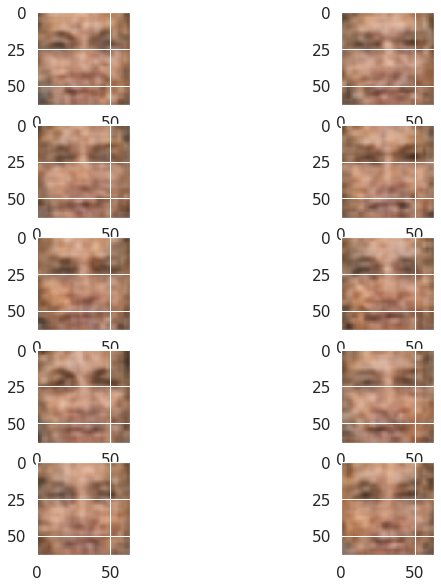

In [ ]:
vecs = get_latent_vecs(X_train_t, trained_enc_5)
mean, std = count_mean_std(vecs)

z = get_z(mean, std, (64, 10, 10))

decode_and_plot_z(z, trained_dec_5)

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
def get_smiling_sad_people(data, number):
    smile = data[data['Smiling'] > 1].index
    smily = np.random.choice(smile,20)

    sadness = data[data['Frowning'] > 1].index
    sad = np.random.choice(sadness,20)
    
    return smily, sad

def plot_people(samples, whole_data):
    plt.figure(figsize=(16, 5))
    for i, gt in enumerate(whole_data[smile]):
        plt.subplot(4, 5, i+1)
        plt.imshow(gt)

(None, None)

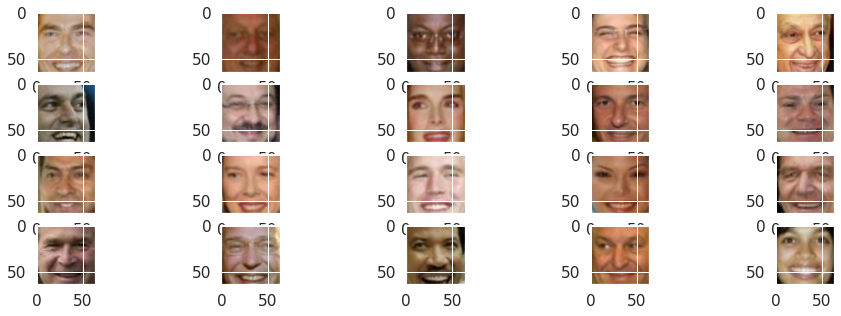

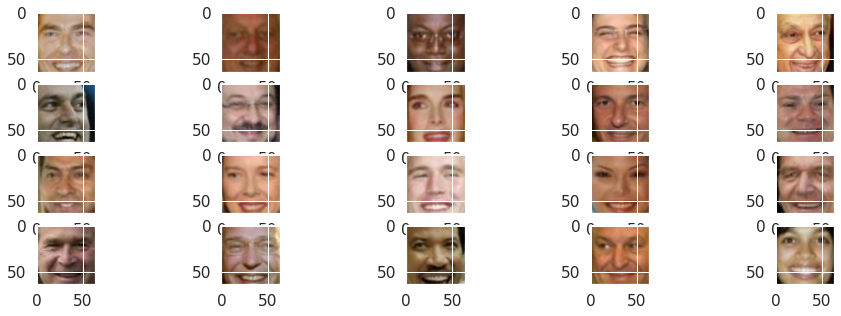

In [ ]:
smile, sad = get_smiling_sad_people(attrs, 20)

plot_people(smile, data), plot_people(sad, data)

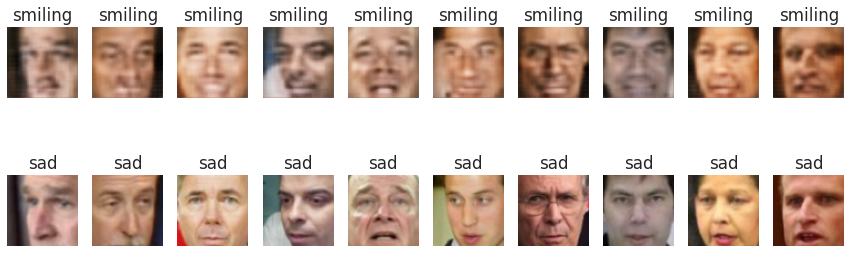

In [ ]:
"""<ваш код здесь>"""
# subtask1
data_smily =  torch.permute(torch.tensor(data[smile], dtype=torch.float32), (0, 3, 1, 2))
data_sadness = torch.permute(torch.tensor(data[sad], dtype=torch.float32), (0, 3, 1, 2))

# subtask 2
vecs_smile = get_latent_vecs(data_smily, trained_enc_5)
vecs_sad = get_latent_vecs(data_sadness, trained_enc_5)

mean_smile, std_smile = count_mean_std(vecs_smile)
mean_sad, std_sad = count_mean_std(vecs_sad)

# subtask 3
difference = mean_smile - mean_sad

# subtask 4
result = vecs_sad + difference

output_for_4 = trained_dec_5(result.to(device))

output_numpy = np.rollaxis(output_for_4.cpu().detach().numpy(), 1, 4)
data_sad_numpy = np.rollaxis(data_sadness.cpu().detach().numpy(), 1, 4)

plt.figure(figsize=(15, 5))
for i, (gt, res) in enumerate(zip(output_numpy[5:15], data_sad_numpy[5:15])):
    plt.subplot(2, 10, i + 1)
    plt.imshow(gt)
    plt.axis('off')
    plt.title('smiling')
    
    plt.subplot(2, 10, i + 11)
    
    plt.imshow(res)
    plt.axis('off')
    plt.title('sad')
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 256
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

dataloaders_mnist = {}
dataloaders_mnist['train'], dataloaders_mnist['val'] = train_loader, test_loader

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
features = 16

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        """<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>"""
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=features*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=784)
        )
            
    def encode(self, x):
        """<реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>"""
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] #
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        #if self.training:
        """<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>"""
        std = torch.exp(0.5 * logsigma) # standard deviation
       
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        #print('eps', eps.shape)
        sample = mu + (eps * std)
            
        return sample
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
        #return mu
    
    def decode(self, z):
        """<реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>"""
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):
        """<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>"""
        #print(x.shape)
        x = self.flatten(x).float()
        #print(x.shape)
        mu, logsigma = self.encode(x)
        #print(mu.shape, logsigma.shape)

        
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.gaussian_sampler(mu, log_var)
        return z

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    #<напишите код для KL-дивергенции, пользуясь формулой выше>
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss 

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    #<binary cross-entropy>
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    #<соедините тут две компоненты лосса. Mind the sign!>
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
def train_VAE(model, optimizer, loss_fn, n_epochs, dataloaders):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for batch, _ in dataloaders['train']:
            #print(batch.shape)
            optimizer.zero_grad()
            reconstruction, mu, logsigma = model(batch.to(device))
            #print(reconstruction.shape)
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = loss_fn(batch.to(device).float(), mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for batch, _ in dataloaders['val']:
                reconstruction, mu, logsigma = model(batch.to(device))
                reconstruction = reconstruction.view(-1, 1, 28, 28)
                loss = loss_fn(batch.to(device).float(), mu, logsigma, reconstruction)
                val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))
        
    return model, train_losses, val_losses

In [ ]:
def small_prep_VAE(model):
    loss_fn = loss_vae
    lr = 0.001
    torch.manual_seed(42)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-04)

    return model, optimizer, loss_fn

In [ ]:
var_autoencoder = VAE().to(device)

trained_vae, train_loss_vae, val_loss_vae = train_VAE(*small_prep_VAE(var_autoencoder), 50, dataloaders_mnist)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
def VAE_eval_plot(model, test):
    model.eval()
    with torch.no_grad():
          for batch, _ in test:
            print(batch.shape)
            reconstruction, mu, logsigma = model(batch.to(device))
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            print(reconstruction.shape)
            reconstruction = np.rollaxis(reconstruction.detach().cpu().numpy(), 1, 4)
            print(reconstruction.shape)
            ground_truth = np.rollaxis(batch.numpy(), 1, 4)
            print(ground_truth.shape)
            break
            
    plt.figure(figsize=(10, 5))
    for i, (gt, res) in enumerate(zip(ground_truth[:5], reconstruction[:5])):
        plt.subplot(2, 5, i+1)
        plt.imshow(np.squeeze(gt))
        plt.grid(None)
        plt.axis('off')

        plt.subplot(2, 5, i+6)
        plt.imshow(np.squeeze(res))
        plt.grid(None)
        plt.axis('off')

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
(256, 28, 28, 1)
(256, 28, 28, 1)


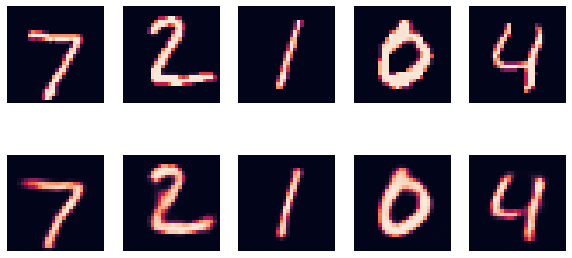

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
VAE_eval_plot(trained_vae, dataloaders_mnist['val'])

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 16) for i in range(10)]) # генерируем случайные векторы
z = torch.FloatTensor(z) # перводим в тензор

In [ ]:
# получаем по каждой фотке mean, std
mean_vecs = []
std_vecs = []
with torch.no_grad():
    for img, _ in dataloaders_mnist['val']:
        #print(img.shape)
        mean, log_var = trained_vae.encode(img.to(device))
        mean_vecs.append(mean)
        std_vecs.append(log_var)
        

# склеиваем и считаем mean, std
total_mean_vecs = torch.cat(mean_vecs, dim=0)
mean = torch.mean(total_mean_vecs, dim=0)
total_std_vecs = torch.exp(0.5 * torch.cat(mean_vecs, dim=0))
std = torch.std(total_std_vecs, dim=0)

# получаем итоговый z
z = torch.FloatTensor(z).to(device) * std + mean


output = trained_vae.decode(z) # output = <скормите z декодеру>

# преобразуем наш флатэн в формат изображения для вывода
resulted = nn.Unflatten(dim=1, unflattened_size=(28,28,1))
output_new = resulted(output)

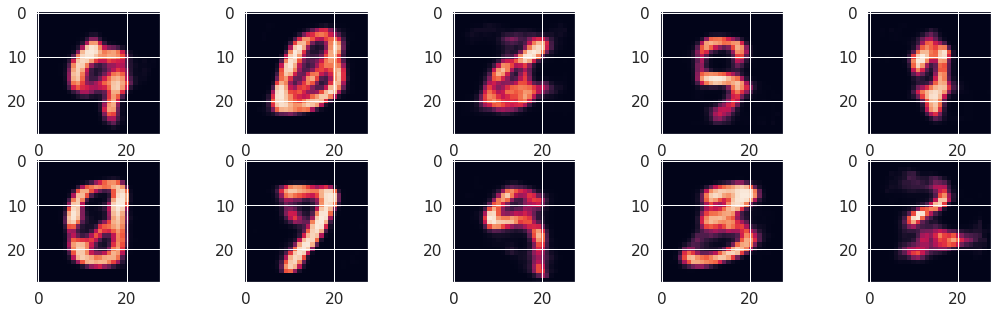

In [ ]:
# <выведите тут полученные картинки>
plt.figure(figsize=(18, 5))
for i in range(output_new.shape[0]):
    plt.subplot(2,output.shape[0] // 2, i + 1)
    generated = output_new[i].cpu().detach().numpy()
    plt.imshow(np.squeeze(generated))

plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
trained_vae

VAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=784, bias=True)
  )
)

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

#<ваш код получения латентных представлений, применения TSNE и визуализации>
encoded_samples = []
for img, label in test_dataset:
    # Encode image
    trained_vae.eval()
    with torch.no_grad():
        encoded_img  = trained_vae.get_latent_vector(img.to(device))

    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
  
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        """<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>"""
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=794, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=features*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features + 10, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=784)
        )
        
    def encode(self, x, class_num):
        """<реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>"""
        x = self.flatten(x).float()
        #print(f"flattened{x.shape}")
        x_concatened = torch.cat([x, class_num], 1)
        #print("Concateneted", x_concatened.shape)
        x = self.encoder(x_concatened).view(-1, 2, features)
        #print('After_encoder',x.shape)
        mu = x[:, 0, :] # the first feature values as mean
        #print('mu', mu.shape)
        
        logsigma = x[:, 1, :] #
        #print('sigma', logsigma.shape)
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        #if self.training:
        """<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>"""
        std = torch.exp(0.5 * logsigma) # standard deviation
        #print('std', std.shape)
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        #print('eps', eps.shape)
        sample = mu + (eps * std)
        #print('sample', sample.shape)    
        return sample
        #else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            #return mu
    
    def decode(self, z, class_num):
        """<реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>"""
        z_concated = torch.cat([z, class_num], 1)
        x = self.decoder(z_concated)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x, class_num):
        """<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>"""
        x = self.flatten(x).float()
        #print(x.shape)
        mu, logsigma, class_num = self.encode(x, class_num)
        #print(mu.shape, logsigma.shape)

        
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return reconstruction, mu, logsigma, 
    
    def get_latent_vector(self, x, class_num):
        x = self.flatten(x).float()
        x_concatened = torch.cat([x, class_num], 1)
        x = self.encoder(x_concatened).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.gaussian_sampler(mu, log_var)
        return z

In [ ]:
cond_autoencoder = CVAE().to(device)

In [ ]:
cond_dim = train_loader.dataset.train_labels.unique().size(0)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning:

train_labels has been renamed targets



In [ ]:
def one_hot(labels, class_size): 
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [ ]:
criterion = loss_vae

#autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(cond_autoencoder.parameters(), lr=0.001, weight_decay=1e-04)#<Ваш любимый оптимизатор>

In [ ]:
#<обучите модель на датасете MNIST>
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    cond_autoencoder.train()
    train_losses_per_epoch = []
    for batch, cond in train_loader:
        #print(batch.shape)
        cond = one_hot(cond, cond_dim)
        optimizer.zero_grad()
        reconstruction, mu, logsigma = cond_autoencoder(batch.to(device), cond.to(device))
        #print(reconstruction.shape)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    cond_autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, cond in test_loader:
            cond = one_hot(cond, cond_dim)
            reconstruction, mu, logsigma = cond_autoencoder(batch.to(device), cond.to(device))
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
"""<тут нужно научиться сэмплировать из декодера цифры определенного класса>"""
z = np.array([np.random.normal(0, 1, 16) for i in range(1)]) # генерируем случайный вектор
z = torch.FloatTensor(z) # перводим в тензор

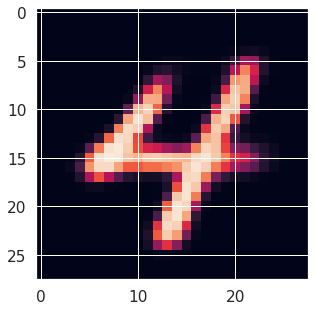

In [ ]:
mean_vecs = []
std_vecs = []
with torch.no_grad():
    for img, cond in test_loader:
        #print(img.shape)
        #print(cond.shape)
        cond = one_hot(cond, cond_dim)
        #print(cond.shape)
        mean, log_var, label = cond_autoencoder.encode(img.to(device), cond.to(device))
        mean_vecs.append(mean)
        std_vecs.append(log_var)
        

# склеиваем и считаем mean, std
total_mean_vecs = torch.cat(mean_vecs, dim=0)
mean = torch.mean(total_mean_vecs, dim=0)
total_std_vecs = torch.exp(0.5 * torch.cat(mean_vecs, dim=0))
std = torch.std(total_std_vecs, dim=0)

# получаем итоговый z
z = z.to(device) * std + mean

# закидываем циферку и полученный вектор в decoder и получаем четкий результат
output = cond_autoencoder.decode(z, one_hot(torch.LongTensor([4]), cond_dim).to(device)) # output = <скормите z декодеру>
resulted = nn.Unflatten(dim=1, unflattened_size=(28,28,1))
output_new = resulted(output)

plt.figure(figsize=(18, 5))

generated = output_new.cpu().detach().numpy()
plt.imshow(np.squeeze(generated))

plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>
encoded_samples = []
for img, label in test_dataset:
    # Encode image

    cond_autoencoder.eval()
    with torch.no_grad():
        encoded_img  = cond_autoencoder.get_latent_vector(img.to(device), 
                                                     one_hot(torch.LongTensor([label]), cond_dim).to(device))

    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
  
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
# X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
encoder_5 = Encoder_5().to(device)
decoder_5 = Decoder_5().to(device)

loss_fn = F.mse_loss
lr= 0.001
torch.manual_seed(42)

params_to_optimize = [
    {'params': encoder_5.parameters()},
    {'params': decoder_5.parameters()}
]

optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-04)

In [ ]:
def add_noise(inputs):
     noise = torch.randn_like(inputs)
     return inputs + noise

In [ ]:
def train_new_noise(encoder, decoder, optimizer, loss_fn, epochs, data):
    #since = time.time()
    
    best_wts_encoder = copy.deepcopy(encoder.state_dict())
    best_wts_decoder = copy.deepcopy(decoder.state_dict())
    
    best_val_loss = None
    
    train_losses = []
    val_losses = []

    #total_l
    for epoch in range(epochs):
        print(f'Epoch {epoch}')
        
        encoder.train()
        decoder.train()
        running_train_loss = 0.0
        
        for i, X_batch in enumerate(data['train']):
            optimizer.zero_grad()
            #print(X_batch.shape)
            latent_space = encoder(add_noise(X_batch.to(device)))
            #print(latent_space.shape)
            reconstructed = decoder(latent_space)
            #print('Latent_space_dim', latent_space.shape)
            loss = loss_fn(reconstructed, X_batch.to(device))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * X_batch.size(0)
            
        train_losses.append(running_train_loss / len(data['train']))
        
        encoder.eval()
        decoder.eval()
        running_val_loss = 0.0

        for X_batch_val in data['val']:
            
            latent_space_val = encoder(X_batch_val.to(device))
            reconstructed_val = decoder(latent_space_val)
            #print(latent_space_val.shape)
            loss_val = loss_fn(reconstructed_val, X_batch_val.to(device))
            running_val_loss += loss_val.item() * X_batch_val.size(0)

        epoch_val_loss = running_val_loss / len(data['val'])
        val_losses.append(running_val_loss / len(data['val']))

        print('Train loss {:.4f}, Validation loss {:.4f}'.format(running_train_loss / len(data['train']), running_val_loss / len(data['val'])))
        time.sleep(1)

        clear_output(wait=True)
        plt.figure(figsize=(10, 5)) 
        for k in range(5):
            plt.subplot(2, 5, k+1)
            plt.imshow(np.rollaxis(X_batch_val[k].detach().cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real', fontsize=12)          
            plt.axis('off')

            plt.subplot(2, 5, k+6)
            plt.imshow(np.rollaxis(reconstructed_val[k].detach().cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Generated', fontsize=12)
            plt.axis('off')
                       
        plt.show()
        
        if best_val_loss is None:
            best_val_loss = epoch_val_loss
            best_wts_encoder = copy.deepcopy(encoder.state_dict())
            best_wts_decoder = copy.deepcopy(decoder.state_dict())     
        elif epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_wts_encoder = copy.deepcopy(encoder.state_dict())
            best_wts_decoder = copy.deepcopy(decoder.state_dict())   
            
            
    sns.set(style="darkgrid", font_scale=1.4)
    
    plt.title('Train/val losses during training process')
    plt.plot(np.arange(epochs), train_losses, label='train')
    plt.plot(np.arange(epochs), val_losses, label='val')
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    
    print('Best valid loss', best_val_loss)
    return encoder, decoder, train_losses, val_losses

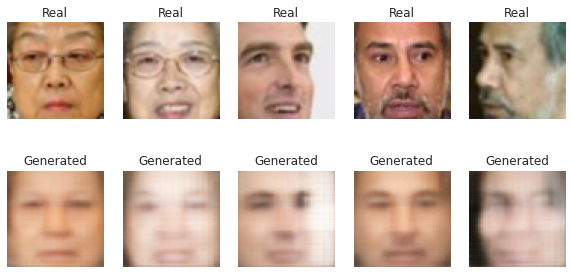

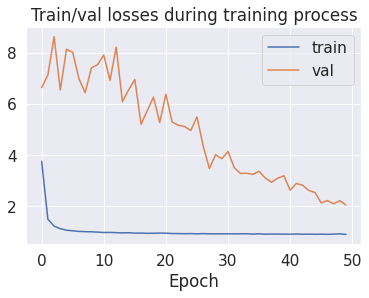

Best valid loss 2.050829553604126
CPU times: user 1min 52s, sys: 928 ms, total: 1min 53s
Wall time: 2min 42s


In [ ]:
%%time
trained_enc_5, trained_dec_5, train_loss_5, val_loss_5 = train_new_noise(encoder_5, decoder_5, optimizer, 
                                                                   loss_fn, 50, dataloaders) # _noise

torch.Size([128, 3, 64, 64])
latent torch.Size([128, 64, 10, 10])
(128, 64, 64, 3)
(128, 64, 64, 3)


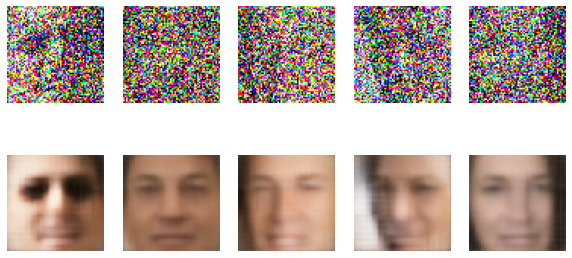

In [ ]:
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>
trained_enc_5.eval()
trained_dec_5.eval()
with torch.no_grad():
    for batch in dataloaders['val']:
        noisy_batch = add_noise(batch)
        # noisy_batch = batch
        print(batch.shape)
        latent_val = trained_enc_5(batch.to(device, dtype=torch.float))
        reconstracted = trained_dec_5(latent_val)
        print('latent', latent_val.shape)
        reconstruction = np.rollaxis(reconstracted.detach().cpu().numpy(), 1, 4)
        print(reconstruction.shape)
        ground_truth = np.rollaxis(noisy_batch.numpy(), 1, 4)
        print(ground_truth.shape)
        break   
        
plt.figure(figsize=(10, 5))
for i, (gt, res) in enumerate(zip(ground_truth[:5], reconstruction[:5])):
    plt.subplot(2, 5, i+1)
    plt.imshow(gt)
    plt.grid(None)
    plt.axis('off')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(res)
    plt.grid(None)
    plt.axis('off')

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
features = 16

class VAE_Retrieval(nn.Module):
    def __init__(self):
        super(VAE_Retrieval, self).__init__()
        """<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>"""
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=12288, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=features*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=12288)
        )
            
    def encode(self, x):
        """<реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>"""
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] #
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        #if self.training:
        """<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>"""
        std = torch.exp(0.5 * logsigma) # standard deviation
       
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        #print('eps', eps.shape)
        sample = mu + (eps * std)
            
        return sample
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
        #return mu
    
    def decode(self, z):
        """<реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>"""
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):
        """<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>"""
        #print(x.shape)
        x = self.flatten(x).float()
        #print(x.shape)
        mu, logsigma = self.encode(x)
        #print(mu.shape, logsigma.shape)

        
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.gaussian_sampler(mu, log_var)
        return z

In [ ]:
vae_retrieval = VAE_Retrieval().to(device)
criterion = loss_vae

#autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(vae_retrieval.parameters(), lr=0.001, weight_decay=1e-04)#<Ваш любимый оптимизатор>
#<обучите модель на датасете MNIST>
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    vae_retrieval.train()
    train_losses_per_epoch = []
    for batch in dataloaders['train']:
        #print(batch.shape)
        optimizer.zero_grad()
        reconstruction, mu, logsigma = vae_retrieval(batch.to(device))
        #print(reconstruction.shape)
        reconstruction = reconstruction.view(-1, 3, 64, 64)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    vae_retrieval.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in dataloaders['val']:
            reconstruction, mu, logsigma = vae_retrieval(batch.to(device))
            reconstruction = reconstruction.view(-1, 3, 64, 64)
            loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#codes = <поучите латентные представления картинок из трейна>
latent_vecs = []
with torch.no_grad():
    for img in X_train_t:
        img = img[None,:,:,:]
        img = img.to(device)
        latent_space = vae_retrieval.get_latent_vector(img)
        latent_vecs.append(latent_space)

codes = torch.cat(latent_vecs, dim=0)

In [ ]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=50).fit(codes.detach().cpu().numpy())

In [ ]:
def get_similar(image, n_neighbors=3):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей
    img = image[None,:,:,:]
    img = img.to(device)
    
    code = vae_retrieval.get_latent_vector(img) #<получение латентного представления image>
    
    #(distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)
    distances, indexes = nn.kneighbors(code.detach().cpu().numpy(), n_neighbors=n_neighbors)
    return distances, indexes

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    #print(image.shape)
    distances,neighbors = get_similar(image,n_neighbors=11)
    print(distances)
    distances = distances[0]
    photo_neighbours = train_photos[neighbors][0]
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(np.rollaxis(image.detach().cpu().numpy(), 0, 3))
    plt.title("Original image")
    plt.grid(None)
    plt.axis('off')
    for i in range(11):
        plt.subplot(3,4,i+2)
        #print(photo_neighbours[i].shape)
        plt.imshow(photo_neighbours[i])
        plt.title("Dist=%.3f"%distances[i])
        plt.grid(None)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

[[1.6945314 1.7591023 1.869529  1.899907  1.9382809 1.9906323 1.9952747
  2.031332  2.0373201 2.0664134 2.0851157]]


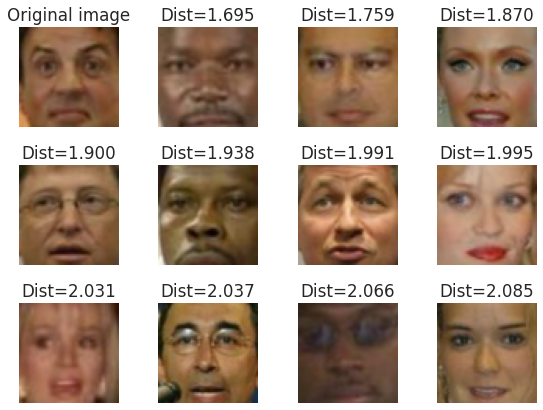

In [ ]:
#<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>
show_similar(X_val_t[1])